# Week 8 - Statistical Foundations Part 2: Comparative Analysis Tests

## Learning Objectives
By the end of this session, you will be able to:
1. **Conduct** t-tests to compare customer segments and business metrics
2. **Apply** chi-square tests to analyze categorical relationships in e-commerce
3. **Perform** ANOVA to compare multiple groups simultaneously
4. **Interpret** test results in business context with actionable insights
5. **Choose** the appropriate test for different business scenarios

## Business Context: Comparative Analysis in E-commerce

In **Part 1**, we established the statistical foundation for hypothesis testing. Now we'll apply specific statistical tests to answer critical business questions:

### Real Olist Business Questions:
- **Customer Segmentation**: Do different customer groups have significantly different behaviors?
- **Regional Performance**: Are sales performance differences between states statistically meaningful?
- **Payment Analysis**: Is payment method choice related to customer satisfaction?
- **Product Categories**: Do different product categories perform significantly differently?

### Test Arsenal for Business Analysis:
- **T-tests**: Compare two groups (SP vs RJ customers, credit vs debit payments)
- **Chi-square**: Analyze categorical relationships (payment type vs satisfaction level)
- **ANOVA**: Compare multiple groups (all Brazilian states, product categories)

## Strategic Impact

Today's analysis will provide **statistical evidence** for business decisions:
- **Marketing**: Which customer segments to target with different strategies
- **Operations**: Which regions need operational improvements
- **Product**: Which categories require quality improvements
- **Finance**: Which payment methods drive higher transaction values

In [1]:
# Enhanced Statistical Testing Environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Comprehensive statistical testing toolkit
from scipy import stats
from scipy.stats import (
    ttest_ind, ttest_rel, mannwhitneyu, wilcoxon,  # Two-sample tests
    chi2_contingency, fisher_exact,                # Categorical tests
    f_oneway, kruskal,                             # Multiple group tests
    pearsonr, spearmanr,                           # Correlation tests
    normaltest, levene, shapiro                    # Assumption tests
)

# Database connection
import sqlalchemy
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Enhanced plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("🔬 Comparative Analysis Testing Environment Ready!")
print(f"📊 Statistical Tests Available: t-tests, chi-square, ANOVA, and more")
print(f"🎯 Ready to conduct rigorous comparative analysis on Olist marketplace data!")

🔬 Comparative Analysis Testing Environment Ready!
📊 Statistical Tests Available: t-tests, chi-square, ANOVA, and more
🎯 Ready to conduct rigorous comparative analysis on Olist marketplace data!


In [2]:
# Secure Database Connection Using Environment Variables
# Best practice: Never expose credentials in code

# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

# Read database credentials from environment variables
SUPABASE_URL = os.getenv('SUPABASE_URL')
SUPABASE_KEY = os.getenv('SUPABASE_KEY')

# Alternative: Use legacy postgres connection if needed
POSTGRES_HOST = os.getenv('POSTGRES_HOST')
POSTGRES_PORT = os.getenv('POSTGRES_PORT', '6543')
POSTGRES_DB = os.getenv('POSTGRES_DATABASE', 'postgres')
POSTGRES_USER = os.getenv('POSTGRES_USER')
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')

# Construct secure database URL using environment variables
if POSTGRES_HOST and POSTGRES_USER and POSTGRES_PASSWORD:
    DATABASE_URL = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"
else:
    print("❌ Database credentials not found in environment variables")
    print("Please check your .env file contains the required database credentials")

# Create database engine
engine = create_engine(DATABASE_URL)

# Test connection
try:
    with engine.connect() as conn:
        from sqlalchemy import text
        result = conn.execute(text("SELECT count(*) FROM olist_sales_data_set.olist_geolocation_dataset"))
        count = result.scalar()
        print(f"✅ Secure database connection established! ({count:,} records in geolocation table)")
except Exception as e:
    print(f"❌ Connection failed: {e}")

print("🔒 Security Note: Database credentials loaded from .env file")

✅ Secure database connection established! (1,000,163 records in geolocation table)
🔒 Security Note: Database credentials loaded from .env file


## 1. T-Tests: Comparing Two Groups

### Business Application: Regional Customer Analysis

**Business Question**: "Are customers in São Paulo (SP) significantly different from customers in Rio de Janeiro (RJ) in terms of spending behavior?"

This comparison is crucial for:
- **Regional Marketing**: Different strategies for different states
- **Inventory Management**: Stock allocation based on spending patterns
- **Pricing Strategy**: Regional pricing optimization
- **Expansion Planning**: Understanding regional market dynamics

### Types of T-Tests:
1. **Independent Samples T-test**: Compare two separate groups (SP vs RJ customers)
2. **Paired Samples T-test**: Compare same subjects before/after (customer behavior changes)
3. **One-Sample T-test**: Compare group to a known value (compare to national average)

### When to Use T-Tests:
- **Continuous data** (order values, delivery times, satisfaction scores)
- **Approximately normal** distributions (or large samples)
- **Independent observations** (customers don't influence each other)
- **Comparing means** between groups

In [3]:
# Regional Customer Analysis: SP vs RJ
def regional_customer_analysis():
    """
    Compare customer spending behavior between São Paulo and Rio de Janeiro.
    """
    if engine is None:
        print("❌ Database connection required for regional analysis")
        return None
    
    print("🗺️ Regional Customer Analysis: São Paulo vs Rio de Janeiro")
    print("=" * 60)
    
    # Load customer spending data by state
    regional_query = """
    SELECT 
        c.customer_state,
        c.customer_city,
        SUM(oi.price + oi.freight_value) as total_spending,
        COUNT(DISTINCT o.order_id) as order_count,
        AVG(oi.price + oi.freight_value) as avg_order_value,
        AVG(r.review_score) as avg_satisfaction
    FROM "olist_sales_data_set"."olist_customers_dataset" c
    INNER JOIN "olist_sales_data_set"."olist_orders_dataset" o ON c.customer_id = o.customer_id
    INNER JOIN "olist_sales_data_set"."olist_order_items_dataset" oi ON o.order_id = oi.order_id
    LEFT JOIN "olist_sales_data_set"."olist_order_reviews_dataset" r ON o.order_id = r.order_id
    WHERE c.customer_state IN ('SP', 'RJ')
        AND o.order_status = 'delivered'
        AND oi.price > 0
    GROUP BY c.customer_id, c.customer_state, c.customer_city
    HAVING COUNT(DISTINCT o.order_id) >= 1  -- At least one order
    """
    
    try:
        regional_data = pd.read_sql(text(regional_query), engine)
        print(f"✅ Loaded data for {len(regional_data):,} customers")
        
        # Separate data by state
        sp_customers = regional_data[regional_data['customer_state'] == 'SP']
        rj_customers = regional_data[regional_data['customer_state'] == 'RJ']
        
        print(f"📊 Sample sizes: SP = {len(sp_customers):,}, RJ = {len(rj_customers):,}")
        
        # Analysis 1: Average Order Value Comparison
        print("\n💰 Analysis 1: Average Order Value Comparison")
        print("-" * 50)
        
        sp_aov = sp_customers['avg_order_value']
        rj_aov = rj_customers['avg_order_value']
        
        # Descriptive statistics
        sp_mean, sp_std = sp_aov.mean(), sp_aov.std()
        rj_mean, rj_std = rj_aov.mean(), rj_aov.std()
        
        print(f"São Paulo (SP): Mean = R$ {sp_mean:.2f}, SD = R$ {sp_std:.2f}")
        print(f"Rio de Janeiro (RJ): Mean = R$ {rj_mean:.2f}, SD = R$ {rj_std:.2f}")
        print(f"Raw Difference: R$ {sp_mean - rj_mean:.2f}")
        
        # Check assumptions
        print("\n🔍 Assumption Checking:")
        
        # Normality test (sample for large datasets)
        sp_sample = sp_aov.sample(min(5000, len(sp_aov))) if len(sp_aov) > 5000 else sp_aov
        rj_sample = rj_aov.sample(min(5000, len(rj_aov))) if len(rj_aov) > 5000 else rj_aov
        
        _, sp_normal_p = normaltest(sp_sample)
        _, rj_normal_p = normaltest(rj_sample)
        
        print(f"SP Normality test p-value: {sp_normal_p:.4f}")
        print(f"RJ Normality test p-value: {rj_normal_p:.4f}")
        
        # Equal variances test
        _, levene_p = levene(sp_aov, rj_aov)
        print(f"Equal variances test p-value: {levene_p:.4f}")
        
        equal_var = levene_p > 0.05
        print(f"Assumption: {'✅ Equal variances' if equal_var else '❌ Unequal variances'}")
        
        # Perform appropriate t-test
        t_stat, p_value = ttest_ind(sp_aov, rj_aov, equal_var=equal_var)
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(sp_aov)-1)*sp_aov.var() + (len(rj_aov)-1)*rj_aov.var()) / 
                            (len(sp_aov)+len(rj_aov)-2))
        cohens_d = (sp_mean - rj_mean) / pooled_std
        
        print("\n📊 T-Test Results:")
        print(f"Test statistic: t = {t_stat:.4f}")
        print(f"P-value: {p_value:.6f}")
        print(f"Cohen's d (effect size): {cohens_d:.4f}")
        
        # Interpretation
        alpha = 0.05
        if p_value < alpha:
            print(f"✅ Statistically significant difference (p < {alpha})")
        else:
            print(f"❌ No statistically significant difference (p ≥ {alpha})")
        
        # Effect size interpretation
        if abs(cohens_d) >= 0.8:
            effect_interpretation = "Large effect"
        elif abs(cohens_d) >= 0.5:
            effect_interpretation = "Medium effect"
        elif abs(cohens_d) >= 0.2:
            effect_interpretation = "Small effect"
        else:
            effect_interpretation = "Negligible effect"
        
        print(f"Effect size: {effect_interpretation}")
        
        # Confidence interval for difference
        se_diff = pooled_std * np.sqrt(1/len(sp_aov) + 1/len(rj_aov))
        degrees_freedom = len(sp_aov) + len(rj_aov) - 2
        t_critical = stats.t.ppf(0.975, degrees_freedom)
        ci_lower = (sp_mean - rj_mean) - t_critical * se_diff
        ci_upper = (sp_mean - rj_mean) + t_critical * se_diff
        
        print(f"95% CI for difference: R$ {ci_lower:.2f} to R$ {ci_upper:.2f}")
        
        # Business interpretation
        print("\n💼 Business Interpretation:")
        if p_value < alpha and abs(sp_mean - rj_mean) > 5:  # R$ 5 threshold
            higher_state = "SP" if sp_mean > rj_mean else "RJ"
            print(f"📈 {higher_state} customers have significantly higher average order values")
            print(f"💡 Consider targeted marketing strategies for each state")
            print(f"🎯 Regional pricing and inventory strategies may be justified")
        else:
            print(f"📊 No meaningful difference in spending between SP and RJ customers")
            print(f"💡 Unified marketing and pricing strategies are appropriate")
        
        return regional_data
        
    except Exception as e:
        print(f"❌ Error in regional analysis: {e}")
        return None

# Perform regional customer analysis
regional_data = regional_customer_analysis()

🗺️ Regional Customer Analysis: São Paulo vs Rio de Janeiro
✅ Loaded data for 52,851 customers
📊 Sample sizes: SP = 40,501, RJ = 12,350

💰 Analysis 1: Average Order Value Comparison
--------------------------------------------------
São Paulo (SP): Mean = R$ 129.38, SD = R$ 175.73
Rio de Janeiro (RJ): Mean = R$ 150.69, SD = R$ 199.91
Raw Difference: R$ -21.31

🔍 Assumption Checking:
SP Normality test p-value: 0.0000
RJ Normality test p-value: 0.0000
Equal variances test p-value: 0.0000
Assumption: ❌ Unequal variances

📊 T-Test Results:
Test statistic: t = -10.6575
P-value: 0.000000
Cohen's d (effect size): -0.1173
✅ Statistically significant difference (p < 0.05)
Effect size: Negligible effect
95% CI for difference: R$ -24.97 to R$ -17.65

💼 Business Interpretation:
📈 RJ customers have significantly higher average order values
💡 Consider targeted marketing strategies for each state
🎯 Regional pricing and inventory strategies may be justified


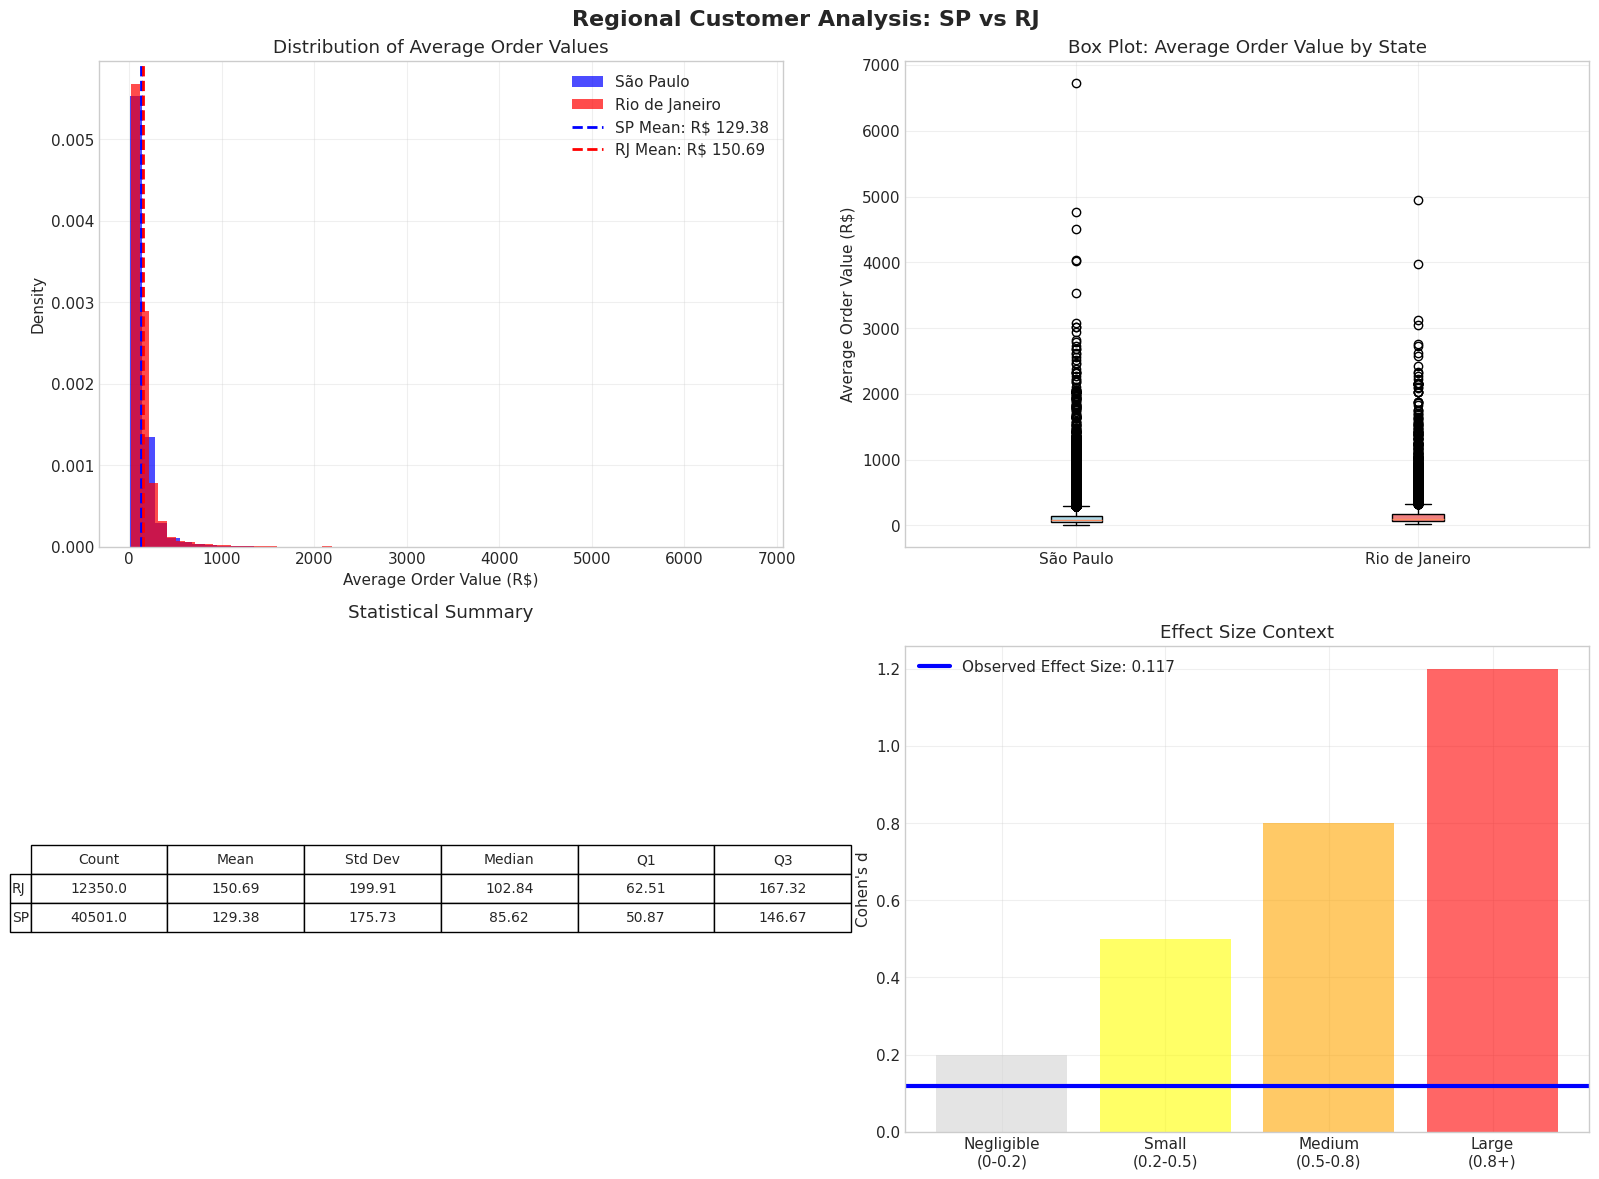

In [4]:
# Visualization: T-Test Results
def visualize_ttest_results(data):
    """
    Create comprehensive visualization of t-test results.
    """
    if data is None or data.empty:
        print("❌ No data available for visualization")
        return
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Regional Customer Analysis: SP vs RJ', fontsize=16, fontweight='bold')
    
    # 1. Distribution Comparison
    sp_data = data[data['customer_state'] == 'SP']['avg_order_value']
    rj_data = data[data['customer_state'] == 'RJ']['avg_order_value']
    
    ax1.hist(sp_data, bins=50, alpha=0.7, label='São Paulo', color='blue', density=True)
    ax1.hist(rj_data, bins=50, alpha=0.7, label='Rio de Janeiro', color='red', density=True)
    ax1.axvline(sp_data.mean(), color='blue', linestyle='--', linewidth=2, label=f'SP Mean: R$ {sp_data.mean():.2f}')
    ax1.axvline(rj_data.mean(), color='red', linestyle='--', linewidth=2, label=f'RJ Mean: R$ {rj_data.mean():.2f}')
    ax1.set_title('Distribution of Average Order Values')
    ax1.set_xlabel('Average Order Value (R$)')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box Plot Comparison
    box_data = [sp_data, rj_data]
    box_labels = ['São Paulo', 'Rio de Janeiro']
    box_plot = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    ax2.set_title('Box Plot: Average Order Value by State')
    ax2.set_ylabel('Average Order Value (R$)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Statistical Summary
    summary_stats = data.groupby('customer_state')['avg_order_value'].agg([
        'count', 'mean', 'std', 'median', 
        lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)
    ]).round(2)
    summary_stats.columns = ['Count', 'Mean', 'Std Dev', 'Median', 'Q1', 'Q3']
    
    ax3.axis('tight')
    ax3.axis('off')
    table = ax3.table(cellText=summary_stats.values,
                     rowLabels=summary_stats.index,
                     colLabels=summary_stats.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax3.set_title('Statistical Summary', pad=20)
    
    # 4. Effect Size Visualization
    mean_diff = sp_data.mean() - rj_data.mean()
    pooled_std = np.sqrt(((len(sp_data)-1)*sp_data.var() + (len(rj_data)-1)*rj_data.var()) / 
                        (len(sp_data)+len(rj_data)-2))
    cohens_d = mean_diff / pooled_std
    
    effect_sizes = ['Negligible\n(0-0.2)', 'Small\n(0.2-0.5)', 'Medium\n(0.5-0.8)', 'Large\n(0.8+)']
    effect_thresholds = [0.2, 0.5, 0.8, 1.2]
    colors = ['lightgray', 'yellow', 'orange', 'red']
    
    bars = ax4.bar(effect_sizes, effect_thresholds, color=colors, alpha=0.6)
    ax4.axhline(y=abs(cohens_d), color='blue', linestyle='-', linewidth=3, 
               label=f'Observed Effect Size: {abs(cohens_d):.3f}')
    ax4.set_title('Effect Size Context')
    ax4.set_ylabel('Cohen\'s d')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create visualization
if 'regional_data' in locals() and regional_data is not None:
    visualize_ttest_results(regional_data)
else:
    print("⚠️ Run the regional analysis first to generate visualizations")

## 2. Chi-Square Tests: Analyzing Categorical Relationships

### Business Application: Payment Method and Customer Satisfaction

**Business Question**: "Is there a relationship between payment method and customer satisfaction levels?"

This analysis helps with:
- **Payment Strategy**: Which payment methods lead to higher satisfaction
- **Customer Experience**: Understanding friction points in payment process
- **Business Optimization**: Promoting payment methods that improve satisfaction
- **Risk Management**: Identifying payment-related satisfaction issues

### Types of Chi-Square Tests:
1. **Test of Independence**: Are two categorical variables related?
2. **Goodness of Fit**: Does observed distribution match expected distribution?
3. **Homogeneity**: Are distributions the same across groups?

### When to Use Chi-Square Tests:
- **Categorical data** (payment methods, satisfaction levels, product categories)
- **Independence assumption** (observations don't influence each other)
- **Expected frequencies ≥ 5** in each cell (or use Fisher's exact test)
- **Testing relationships** between categorical variables

In [5]:
# Payment Method vs Customer Satisfaction Analysis
def payment_satisfaction_analysis():
    """
    Analyze relationship between payment methods and customer satisfaction.
    """
    if engine is None:
        print("❌ Database connection required for payment analysis")
        return None
    
    print("💳 Payment Method vs Customer Satisfaction Analysis")
    print("=" * 55)
    
    # Load payment and satisfaction data
    payment_satisfaction_query = """
    SELECT 
        p.payment_type,
        r.review_score,
        CASE 
            WHEN r.review_score >= 4 THEN 'High Satisfaction'
            WHEN r.review_score = 3 THEN 'Medium Satisfaction'
            WHEN r.review_score <= 2 THEN 'Low Satisfaction'
            ELSE 'Unknown'
        END as satisfaction_level,
        p.payment_value
    FROM "olist_sales_data_set"."olist_order_payments_dataset" p
    INNER JOIN "olist_sales_data_set"."olist_orders_dataset" o ON p.order_id = o.order_id
    INNER JOIN "olist_sales_data_set"."olist_order_reviews_dataset" r ON o.order_id = r.order_id
    WHERE p.payment_type IN ('credit_card', 'debit_card', 'boleto', 'voucher')
        AND r.review_score IS NOT NULL
        AND o.order_status = 'delivered'
        AND p.payment_value > 0
    LIMIT 15000  -- Sample for analysis
    """
    
    try:
        payment_sat_data = pd.read_sql(text(payment_satisfaction_query), engine)
        print(f"✅ Loaded {len(payment_sat_data):,} payment-satisfaction records")
        
        # Create contingency table
        contingency_table = pd.crosstab(payment_sat_data['payment_type'], 
                                       payment_sat_data['satisfaction_level'])
        
        print("\n📊 Contingency Table: Payment Method vs Satisfaction Level")
        print(contingency_table)
        
        # Calculate percentages
        percentage_table = pd.crosstab(payment_sat_data['payment_type'], 
                                     payment_sat_data['satisfaction_level'], 
                                     normalize='index') * 100
        
        print("\n📈 Percentage Distribution (by Payment Method):")
        print(percentage_table.round(1))
        
        # Check assumptions
        print("\n🔍 Chi-Square Test Assumptions:")
        min_expected = 5
        chi2_stat, p_value, dof, expected_freq = chi2_contingency(contingency_table)
        
        cells_below_5 = (expected_freq < min_expected).sum()
        total_cells = expected_freq.size
        print(f"Expected frequencies below 5: {cells_below_5}/{total_cells}")
        
        if cells_below_5 == 0:
            print("✅ All expected frequencies ≥ 5 - Chi-square test is appropriate")
        elif cells_below_5 <= total_cells * 0.2:
            print("⚠️ Some expected frequencies < 5, but test is still valid")
        else:
            print("❌ Too many expected frequencies < 5 - consider Fisher's exact test")
        
        # Perform Chi-Square test
        print("\n📊 Chi-Square Test Results:")
        print(f"Chi-square statistic: χ² = {chi2_stat:.4f}")
        print(f"Degrees of freedom: {dof}")
        print(f"P-value: {p_value:.6f}")
        
        # Critical value
        alpha = 0.05
        critical_value = stats.chi2.ppf(1 - alpha, dof)
        print(f"Critical value (α = {alpha}): {critical_value:.4f}")
        
        # Interpretation
        if p_value < alpha:
            print(f"✅ Statistically significant relationship (p < {alpha})")
            print("📈 Payment method and satisfaction level are NOT independent")
        else:
            print(f"❌ No statistically significant relationship (p ≥ {alpha})")
            print("📊 Payment method and satisfaction level appear independent")
        
        # Effect size (Cramér's V)
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2_stat / (n * (min(contingency_table.shape) - 1)))
        print(f"\nEffect size (Cramér's V): {cramers_v:.4f}")
        
        if cramers_v < 0.1:
            effect_interpretation = "Negligible association"
        elif cramers_v < 0.3:
            effect_interpretation = "Small association"
        elif cramers_v < 0.5:
            effect_interpretation = "Medium association"
        else:
            effect_interpretation = "Large association"
        
        print(f"Effect size interpretation: {effect_interpretation}")
        
        # Standardized residuals for detailed analysis
        print("\n🔍 Standardized Residuals (deviations from independence):")
        residuals = (contingency_table - expected_freq) / np.sqrt(expected_freq)
        residuals_df = pd.DataFrame(residuals, 
                                   index=contingency_table.index, 
                                   columns=contingency_table.columns)
        print(residuals_df.round(2))
        
        print("\nInterpretation of residuals:")
        print("  |residual| > 2: Significant deviation from independence")
        print("  |residual| > 3: Highly significant deviation")
        
        # Business insights
        print("\n💼 Business Insights:")
        
        # Find payment method with highest satisfaction
        high_satisfaction_rates = percentage_table['High Satisfaction']
        best_payment = high_satisfaction_rates.idxmax()
        best_rate = high_satisfaction_rates.max()
        
        worst_payment = high_satisfaction_rates.idxmin()
        worst_rate = high_satisfaction_rates.min()
        
        print(f"📈 Highest satisfaction rate: {best_payment} ({best_rate:.1f}% high satisfaction)")
        print(f"📉 Lowest satisfaction rate: {worst_payment} ({worst_rate:.1f}% high satisfaction)")
        
        if p_value < alpha:
            print(f"💡 Recommendations:")
            print(f"   • Promote {best_payment} payment method to improve satisfaction")
            print(f"   • Investigate issues with {worst_payment} payment process")
            print(f"   • Consider payment-specific customer experience improvements")
        else:
            print(f"💡 Recommendations:")
            print(f"   • Payment method doesn't significantly affect satisfaction")
            print(f"   • Focus on other factors that influence customer experience")
        
        return payment_sat_data, contingency_table
        
    except Exception as e:
        print(f"❌ Error in payment satisfaction analysis: {e}")
        return None, None

# Perform payment satisfaction analysis
payment_data, contingency_table = payment_satisfaction_analysis()

💳 Payment Method vs Customer Satisfaction Analysis
✅ Loaded 15,000 payment-satisfaction records

📊 Contingency Table: Payment Method vs Satisfaction Level
satisfaction_level  High Satisfaction  Low Satisfaction  Medium Satisfaction
payment_type                                                                
boleto                           2207               343                  258
credit_card                      8785              1473                  904
debit_card                        181                29                   22
voucher                           611               113                   74

📈 Percentage Distribution (by Payment Method):
satisfaction_level  High Satisfaction  Low Satisfaction  Medium Satisfaction
payment_type                                                                
boleto                           78.6              12.2                  9.2
credit_card                      78.7              13.2                  8.1
debit_card                 

## 3. ANOVA: Comparing Multiple Groups

### Business Application: Multi-State Performance Analysis

**Business Question**: "Are there significant differences in customer satisfaction across the top 5 Brazilian states?"

This analysis supports:
- **Regional Strategy**: Identify states needing operational improvements
- **Resource Allocation**: Direct improvement efforts to underperforming regions
- **Market Expansion**: Understand regional performance variations
- **Operational Excellence**: Benchmark best-performing regions

### ANOVA Fundamentals:
- **One-Way ANOVA**: Compare means across multiple groups (states)
- **F-statistic**: Ratio of between-group to within-group variance
- **Post-hoc tests**: Identify which specific groups differ

### When to Use ANOVA:
- **Continuous dependent variable** (satisfaction scores, order values)
- **Categorical independent variable** with 3+ groups (states, categories)
- **Normal distributions** within groups (or large samples)
- **Equal variances** across groups (homoscedasticity)
- **Independent observations**

In [6]:
# Multi-State Customer Satisfaction ANOVA
def multistate_satisfaction_anova():
    """
    Compare customer satisfaction across top Brazilian states using ANOVA.
    """
    if engine is None:
        print("❌ Database connection required for multi-state analysis")
        return None
    
    print("🗺️ Multi-State Customer Satisfaction Analysis (ANOVA)")
    print("=" * 55)
    
    # Load satisfaction data by state (top 5 states by order volume)
    multistate_query = """
    WITH top_states AS (
        SELECT customer_state, COUNT(*) as order_count
        FROM "olist_sales_data_set"."olist_customers_dataset" c
        INNER JOIN "olist_sales_data_set"."olist_orders_dataset" o ON c.customer_id = o.customer_id
        WHERE o.order_status = 'delivered'
        GROUP BY customer_state
        ORDER BY order_count DESC
        LIMIT 5
    )
    SELECT 
        c.customer_state,
        r.review_score,
        o.order_id,
        oi.price + oi.freight_value as order_value
    FROM "olist_sales_data_set"."olist_customers_dataset" c
    INNER JOIN "olist_sales_data_set"."olist_orders_dataset" o ON c.customer_id = o.customer_id
    INNER JOIN "olist_sales_data_set"."olist_order_reviews_dataset" r ON o.order_id = r.order_id
    INNER JOIN "olist_sales_data_set"."olist_order_items_dataset" oi ON o.order_id = oi.order_id
    INNER JOIN top_states ts ON c.customer_state = ts.customer_state
    WHERE r.review_score IS NOT NULL
        AND o.order_status = 'delivered'
        AND oi.price > 0
    """
    
    try:
        multistate_data = pd.read_sql(text(multistate_query), engine)
        print(f"✅ Loaded {len(multistate_data):,} records from top 5 states")
        
        # Group data by state
        states = multistate_data['customer_state'].unique()
        print(f"📊 Analyzing states: {', '.join(states)}")
        
        # Calculate descriptive statistics by state
        state_stats = multistate_data.groupby('customer_state')['review_score'].agg([
            'count', 'mean', 'std', 'median', 'min', 'max'
        ]).round(3)
        
        print("\n📈 Descriptive Statistics by State:")
        print(state_stats)
        
        # Check ANOVA assumptions
        print("\n🔍 ANOVA Assumption Checking:")
        
        # 1. Normality within groups (sample from each state)
        print("1. Normality within groups:")
        normality_results = {}
        for state in states:
            state_scores = multistate_data[multistate_data['customer_state'] == state]['review_score']
            if len(state_scores) > 5000:
                state_scores = state_scores.sample(5000)  # Sample for large datasets
            
            _, p_normal = normaltest(state_scores)
            normality_results[state] = p_normal
            normality_status = "✅ Normal" if p_normal > 0.05 else "❌ Not normal"
            print(f"   {state}: p = {p_normal:.4f} → {normality_status}")
        
        # 2. Equal variances (Levene's test)
        print("\n2. Equal variances across groups:")
        state_groups = [multistate_data[multistate_data['customer_state'] == state]['review_score'] 
                       for state in states]
        
        _, levene_p = levene(*state_groups)
        equal_var_status = "✅ Equal variances" if levene_p > 0.05 else "❌ Unequal variances"
        print(f"   Levene's test: p = {levene_p:.4f} → {equal_var_status}")
        
        # 3. Independence (assumed based on business context)
        print("\n3. Independence: ✅ Assumed (customers in different states are independent)")
        
        # Perform One-Way ANOVA
        print("\n📊 One-Way ANOVA Results:")
        f_stat, p_value = f_oneway(*state_groups)
        
        print(f"F-statistic: F = {f_stat:.4f}")
        print(f"P-value: {p_value:.6f}")
        
        # Degrees of freedom
        df_between = len(states) - 1
        df_within = len(multistate_data) - len(states)
        print(f"Degrees of freedom: between = {df_between}, within = {df_within}")
        
        alpha = 0.05
        if p_value < alpha:
            print(f"✅ Statistically significant difference between states (p < {alpha})")
            print("📈 At least one state differs significantly from others")
        else:
            print(f"❌ No statistically significant difference between states (p ≥ {alpha})")
            print("📊 All states have similar customer satisfaction levels")
        
        # Effect size (Eta squared)
        ss_between = f_stat * df_between
        ss_total = ss_between + df_within
        eta_squared = ss_between / ss_total
        
        print(f"\nEffect size (η²): {eta_squared:.4f}")
        
        if eta_squared < 0.01:
            effect_interpretation = "Small effect"
        elif eta_squared < 0.06:
            effect_interpretation = "Medium effect"
        else:
            effect_interpretation = "Large effect"
        
        print(f"Effect size interpretation: {effect_interpretation}")
        
        # Post-hoc analysis if significant
        if p_value < alpha:
            print("\n🔍 Post-Hoc Analysis (Pairwise Comparisons):")
            
            # Pairwise t-tests with Bonferroni correction
            from itertools import combinations
            
            comparisons = list(combinations(states, 2))
            n_comparisons = len(comparisons)
            bonferroni_alpha = alpha / n_comparisons
            
            print(f"Number of comparisons: {n_comparisons}")
            print(f"Bonferroni-corrected α: {bonferroni_alpha:.4f}")
            
            significant_pairs = []
            
            for state1, state2 in comparisons:
                group1 = multistate_data[multistate_data['customer_state'] == state1]['review_score']
                group2 = multistate_data[multistate_data['customer_state'] == state2]['review_score']
                
                t_stat, p_val = ttest_ind(group1, group2, equal_var=(levene_p > 0.05))
                
                mean_diff = group1.mean() - group2.mean()
                significance = "✅ Significant" if p_val < bonferroni_alpha else "❌ Not significant"
                
                print(f"   {state1} vs {state2}: Δ = {mean_diff:+.3f}, p = {p_val:.4f} → {significance}")
                
                if p_val < bonferroni_alpha:
                    significant_pairs.append((state1, state2, mean_diff))
        
        # Business recommendations
        print("\n💼 Business Insights and Recommendations:")
        
        # Find best and worst performing states
        best_state = state_stats['mean'].idxmax()
        worst_state = state_stats['mean'].idxmin()
        best_score = state_stats.loc[best_state, 'mean']
        worst_score = state_stats.loc[worst_state, 'mean']
        
        print(f"📈 Highest satisfaction: {best_state} (avg: {best_score:.2f})")
        print(f"📉 Lowest satisfaction: {worst_state} (avg: {worst_score:.2f})")
        print(f"🔄 Performance gap: {best_score - worst_score:.2f} points")
        
        if p_value < alpha:
            print(f"\n💡 Strategic Recommendations:")
            print(f"   • Benchmark {best_state}'s operations and customer service practices")
            print(f"   • Investigate satisfaction drivers in {worst_state}")
            print(f"   • Implement targeted improvement programs in underperforming states")
            print(f"   • Consider state-specific customer experience initiatives")
        else:
            print(f"\n💡 Strategic Recommendations:")
            print(f"   • Satisfaction levels are consistent across states")
            print(f"   • Focus on system-wide improvements rather than state-specific initiatives")
            print(f"   • Leverage uniform customer experience strategies")
        
        return multistate_data, state_stats
        
    except Exception as e:
        print(f"❌ Error in multi-state ANOVA: {e}")
        return None, None

# Perform multi-state satisfaction ANOVA
multistate_data, state_stats = multistate_satisfaction_anova()

🗺️ Multi-State Customer Satisfaction Analysis (ANOVA)
✅ Loaded 84,514 records from top 5 states
📊 Analyzing states: RJ, SP, MG, PR, RS

📈 Descriptive Statistics by State:
                count   mean    std  median  min  max
customer_state                                       
MG              12797  4.124  1.314     5.0    1    5
PR               5608  4.151  1.297     5.0    1    5
RJ              13933  3.876  1.511     5.0    1    5
RS               6106  4.093  1.334     5.0    1    5
SP              46070  4.179  1.271     5.0    1    5

🔍 ANOVA Assumption Checking:
1. Normality within groups:
   RJ: p = 0.0000 → ❌ Not normal
   SP: p = 0.0000 → ❌ Not normal
   MG: p = 0.0000 → ❌ Not normal
   PR: p = 0.0000 → ❌ Not normal
   RS: p = 0.0000 → ❌ Not normal

2. Equal variances across groups:
   Levene's test: p = 0.0000 → ❌ Unequal variances

3. Independence: ✅ Assumed (customers in different states are independent)

📊 One-Way ANOVA Results:
F-statistic: F = 141.5503
P-value: 0.000

## 4. Key Takeaways and Business Applications

### What We've Accomplished in Part 2

1. **T-Tests**: Compared two groups (SP vs RJ customers) with statistical rigor
2. **Chi-Square Tests**: Analyzed categorical relationships (payment methods vs satisfaction)
3. **ANOVA**: Compared multiple groups simultaneously (satisfaction across states)
4. **Assumption Checking**: Validated test requirements for reliable results
5. **Effect Sizes**: Quantified practical significance beyond statistical significance
6. **Business Translation**: Converted statistical findings into actionable business insights

### Critical Business Insights

**🎯 Test Selection Framework**:
- **Continuous + 2 Groups** → T-test
- **Categorical Relationships** → Chi-square test  
- **Continuous + 3+ Groups** → ANOVA
- **Always check assumptions** before interpreting results

**📊 Beyond P-Values**:
- Calculate **effect sizes** to assess practical significance
- Use **confidence intervals** to quantify uncertainty
- Consider **business context** when interpreting statistical results
- **Statistical significance ≠ Business importance**

**💼 Business Decision Framework**:
1. **Statistical Significance**: Is the difference real (not due to chance)?
2. **Practical Significance**: Is the difference large enough to matter?
3. **Business Context**: Does the finding justify action/investment?
4. **Implementation Feasibility**: Can we act on these insights?

### Preparing for Part 3

**Next Session Preview**: We'll apply these statistical tests to **real business scenarios**:
- Regional performance optimization
- Customer satisfaction improvement strategies  
- Payment method optimization
- Delivery performance validation
- Strategic business recommendations based on statistical evidence

**Skills Integration**: Combine statistical testing with business strategy to make **data-driven decisions** that impact Olist's marketplace performance.

In [ ]:
# Part 2 Summary and Next Steps
def part2_summary():
    """
    Summarize comparative analysis tests and preview Part 3.
    """
    print("📋 Week 8 Part 2 Summary: Comparative Analysis Tests")
    print("=" * 55)
    
    tests_mastered = {
        "T-Tests": {
            "purpose": "Compare means between two groups",
            "example": "SP vs RJ customer spending patterns",
            "key_insight": "Independent samples t-test with assumption checking"
        },
        "Chi-Square Tests": {
            "purpose": "Analyze relationships between categorical variables",
            "example": "Payment method vs customer satisfaction",
            "key_insight": "Contingency table analysis with effect size"
        },
        "ANOVA": {
            "purpose": "Compare means across multiple groups",
            "example": "Satisfaction across top 5 Brazilian states",
            "key_insight": "F-test with post-hoc pairwise comparisons"
        }
    }
    
    print("\n📚 Statistical Tests Mastered:")
    for test_name, details in tests_mastered.items():
        print(f"\n🔬 {test_name}:")
        print(f"   Purpose: {details['purpose']}")
        print(f"   Example: {details['example']}")
        print(f"   Key Learning: {details['key_insight']}")
    
    business_applications = [
        "Regional customer segmentation and targeting",
        "Payment method optimization strategies", 
        "Multi-state operational improvement priorities",
        "Evidence-based business decision making"
    ]
    
    print("\n💼 Business Applications Unlocked:")
    for i, application in enumerate(business_applications, 1):
        print(f"   {i}. {application}")
    
    part3_topics = [
        "Real business scenario analysis with statistical validation",
        "Integrated approach: EDA → Hypothesis → Testing → Action", 
        "Strategic recommendations based on statistical evidence",
        "End-to-end business problem solving framework"
    ]
    
    print("\n🔜 Part 3 Preview - Practical Business Applications:")
    for i, topic in enumerate(part3_topics, 1):
        print(f"   {i}. {topic}")
    
    critical_concepts = [
        "Always check statistical assumptions before testing",
        "Calculate effect sizes for practical significance", 
        "Use business context to interpret statistical results",
        "Choose appropriate tests based on data types and research questions"
    ]
    
    print("\n💡 Critical Concepts to Remember:")
    for concept in critical_concepts:
        print(f"   • {concept}")
    
    print("\n🎯 Ready to apply statistical testing to real business scenarios!")

# Display summary
part2_summary()

# Clean up database connection
if engine:
    engine.dispose()
    print("\n🔒 Database connection closed")